In [1]:
from network import * 
from training import *
def plot_parallel_synapse_params(model):
    plt.figure(figsize=(12, 3))
    plt.subplot(1,4,1)
    plt.hist((model.parallel_synapse.ampli.data.cpu().numpy()**2).flatten(), bins=20)
    plt.title('Amplitude histogram')

    plt.subplot(1,4,2)
    plt.hist(model.parallel_synapse.slope.data.cpu().numpy().flatten(), bins=20)
    plt.title('Slope histogram')

    plt.subplot(1,4,3)
    plt.hist(model.parallel_synapse.thres.data.cpu().numpy().flatten(), bins=20)
    plt.title('Threshold histogram')
    
    plt.subplot(1,4,4)
    plt.hist(model.parallel_synapse.scaler.data.cpu().numpy().flatten(), bins=20)
    plt.title('Scaler histogram')
    
    plt.tight_layout()
    plt.show()


def plot_input_histogram_to_parallel_synapse_layer(model, testloader, hidden_act:str = 'sigmoid') -> None:
    '''
    Inputs:
        model: nn.Module
    
    '''
    hidden = []
    final = []
    for inputs, labels in testloader:
        inputs = inputs.view(-1, 28*28)#.to(device)
        
        labels = binary_labels(labels)
        if hidden_act == 'sigmoid':
            hidden.append(torch.sigmoid(model.fc1(inputs)).detach().cpu())
            
        else:
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu())
        final.append(model.parallel_synapse(hidden[-1]).detach().cpu())
    hidden = torch.cat(hidden, dim=0)
    hidden = hidden.data.cpu().numpy()
    final = torch.cat(final, dim=0)
    plt.figure(figsize=(9, 3 ))
    plt.subplot(1,3,1)
    plt.hist(hidden[hidden>0.00001].flatten(), bins=100)
    plt.title('Hidden activation, {:.1f}% > 1e-4'.format((hidden>1e-4).mean() * 100))
    plt.legend()
    plt.xlabel('hidden layer input')
    plt.ylabel('count')
    
    f = model.parallel_synapse
    slope = f.slope
    ampli = f.ampli
    thres = f.thres
    input_dim = slope.shape[1]
    n_data = 100
    output_dim = slope.shape[-1]
    input = torch.linspace(0, hidden.flatten().max(), steps=n_data).reshape(-1, 1)
    input = input.repeat(1, input_dim)
    n_data = input.shape[0]
    n_synapse = slope.shape[0]
    

    x = slope[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim) \
        * (input[:, None, :, None].expand(n_data, n_synapse, input_dim, output_dim)
        - thres[None, :, :, :].expand(n_data, n_synapse, input_dim, output_dim))
    x = torch.tanh(x)
    x = x * (ampli[None, :, :, :]**2 ).expand(n_data, n_synapse, input_dim, output_dim)
    # x = x * f.scaler[None, None, :, :].expand(n_data, n_synapse, input_dim, output_dim)
    x = x.sum(dim=1).squeeze() 
    
    
    plt.subplot(1,3,2)
    plt.hist(final.data.cpu().numpy().flatten(), bins=100, label='MNIST')
    ylim = plt.ylim()
    plt.legend()
    plt.xlabel('output')
    plt.title('Histogram, final layer input')
    
    plt.tight_layout() 
    
    plt.figure(figsize = (10, 4))
    
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.plot(input[:,0].numpy(), x.detach().numpy()[:,:,i], alpha = 0.8)
        plt.title('output-' + str(i+1))
        plt.xlabel('Input')
    plt.tight_layout()
    plt.show()

def plot_result(result):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.plot(result['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.subplot(1,2,2)
    plt.plot(result['accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()

In [2]:

def multiHingeLoss(output, target, margin = 1):
    # output: (batch_size, num_classes)
    # target: (batch_size, num_classes)
    # loss: (batch_size, 1)
    loss = torch.clamp(margin - output * target, min=0)
    return loss.sum(dim=1).mean()

def oneHotLabel(label, num_classes):
    # label: (batch_size, 1)
    # one_hot_label: (batch_size, num_classes)
    batch_size = label.size(0)
    one_hot_label =(-torch.ones(batch_size, num_classes)).scatter_(1, label.view(-1, 1), 1)
    return one_hot_label

def train_models_NN(model, 
                trainloader, 
                testloader,
                regularization = 0.0,
                H = 20, 
                in_dim = 28, 
                out_dim = 10, 
                num_epochs = 20,
                verbose = True, 
                device = torch.device('cpu'),
                model_type = 'parallel'): 
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    losses, acc = [], []
    criterion = nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(trainloader):
            if model_type == 'parallel':
                with torch.no_grad():
                    slope_thres = 0.01
                    mask = (model.parallel_synapse.slope.data < slope_thres) 
                    model.parallel_synapse.slope.data = torch.clamp(model.parallel_synapse.slope.data, min = slope_thres)
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    
                    ampli_thres = 0.1
                    mask = (model.parallel_synapse.ampli.data**2 < ampli_thres) 
                    model.parallel_synapse.thres.data[mask] = torch.rand(mask.sum()) * model.hidden_range[1] + model.hidden_range[0]
                    model.parallel_synapse.ampli.data[mask] = np.sqrt(ampli_thres)
                    
                    # model.parallel_synapse.thres.data = torch.clamp(model.parallel_synapse.thres.data, min = model.hidden_range[0] )
        
            inputs = inputs.view(-1, 28*28).to(device)
            labels = labels.to(device)
            # labels = oneHotLabel(labels, out_dim).to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = F.nll_loss(outputs, labels) 
            
            # loss = multiHingeLoss(outputs, labels) 
            if model_type == 'parallel':
                loss += regularization * (torch.abs(model.parallel_synapse.scaler) - 1).abs().sum()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        losses.append(running_loss / len(trainloader))
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs = inputs.view(-1, 28*28).to(device)
                labels = oneHotLabel(labels, out_dim).to(device)
                outputs = model(inputs)
                total += labels.size(0)
                correct += torch.argmax(outputs, dim = 1).eq(torch.argmax(labels, dim = 1)).sum().item()
        acc.append(100 * correct / total )
        if verbose and epoch % 10 == 0:
            print( f" Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {acc[-1]:.2f}%") 
    
    
    return {
            'model': model,
            'accuracy': acc,
            'loss': losses
            }

In [3]:
class TwoLayerNN(nn.Module):
    '''
    two layered neural network
    '''
    def __init__(self, 
                input_dim: int, 
                hidden_dim: int, 
                output_dim: int) -> None:
        super().__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.1)
    def forward(self, input: Tensor):
        '''
        Inputs:
            input: (n_data, input_dim)

        Returns:
            output: (n_data, output_dim)
        '''
        x = self.dropout(input)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim = 1)
    
def get_hidden_final_activation_2NN(model, testloader):
    model.eval()
    hidden, final = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.view(-1, 28*28).to(device)
            hidden.append(torch.relu(model.fc1(inputs)).detach().cpu().numpy())
            final.append(model.fc2(torch.relu(model.fc1(inputs))).detach().cpu().numpy())
    return np.concatenate(hidden, axis=0), np.concatenate(final, axis=0)
def plot_hidden_final_loss_2NN(model, hidden, final, result):
    # plot histogram of hidden activation
    plt.figure(figsize=(12, 3)) 
    plt.subplot(1,4,3)
    plt.hist(hidden[hidden>0.00001].flatten(), bins=100)
    plt.title('Hidden activation, {:.1f}% > 1e-4'.format((hidden>1e-4).mean() * 100))
    plt.xlabel('Activation')
    plt.ylabel('Count')
    plt.subplot(1,4,4)
    plt.hist(final.flatten(), bins=100)
    plt.title('Final activation')
    plt.xlabel('Activation')
    plt.ylabel('Count')
    plt.subplot(1, 4, 2)
    plt.plot(result['loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.subplot(1, 4, 1)
    plt.plot(result['accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.tight_layout()
    plt.show()

In [7]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

hidden_dim = 10
output_dim = 10
input_dim = 28*28
n_synapse = 3
hidden_range = (0, 20)


 Epoch 1/200, Loss: 0.7740, Accuracy: 85.62%
 Epoch 11/200, Loss: 0.4147, Accuracy: 89.14%
 Epoch 21/200, Loss: 0.4078, Accuracy: 89.20%
 Epoch 31/200, Loss: 0.4012, Accuracy: 89.47%
 Epoch 41/200, Loss: 0.3983, Accuracy: 89.38%
 Epoch 51/200, Loss: 0.3970, Accuracy: 89.07%
 Epoch 61/200, Loss: 0.3982, Accuracy: 88.89%
 Epoch 71/200, Loss: 0.3950, Accuracy: 89.36%
 Epoch 81/200, Loss: 0.3972, Accuracy: 89.40%
 Epoch 91/200, Loss: 0.3950, Accuracy: 89.21%
 Epoch 101/200, Loss: 0.3966, Accuracy: 89.43%
 Epoch 111/200, Loss: 0.3938, Accuracy: 88.96%
 Epoch 121/200, Loss: 0.3942, Accuracy: 89.17%
 Epoch 131/200, Loss: 0.3938, Accuracy: 88.60%
 Epoch 141/200, Loss: 0.3954, Accuracy: 89.50%
 Epoch 151/200, Loss: 0.3942, Accuracy: 89.83%
 Epoch 161/200, Loss: 0.3956, Accuracy: 89.62%
 Epoch 171/200, Loss: 0.3936, Accuracy: 89.77%
 Epoch 181/200, Loss: 0.3944, Accuracy: 89.41%
 Epoch 191/200, Loss: 0.3938, Accuracy: 88.42%


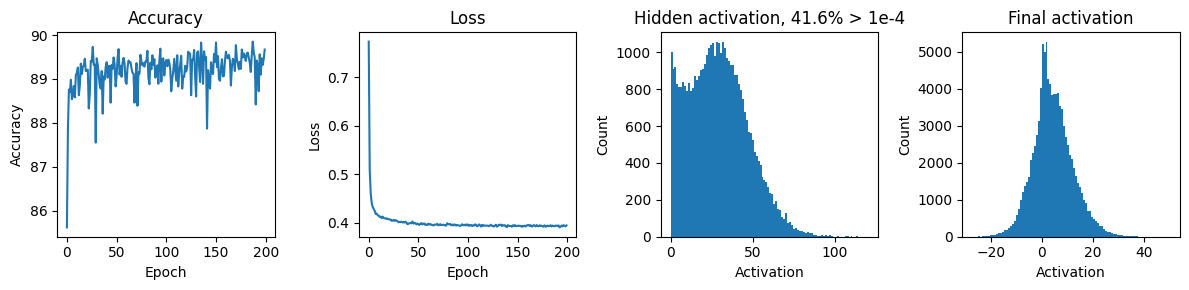

--------------------------------------------------
 Epoch 1/200, Loss: 0.6429, Accuracy: 87.99%
 Epoch 11/200, Loss: 0.3638, Accuracy: 89.68%
 Epoch 21/200, Loss: 0.3547, Accuracy: 90.33%
 Epoch 31/200, Loss: 0.3506, Accuracy: 91.01%
 Epoch 41/200, Loss: 0.3463, Accuracy: 90.94%
 Epoch 51/200, Loss: 0.3425, Accuracy: 90.99%
 Epoch 61/200, Loss: 0.3424, Accuracy: 91.08%
 Epoch 71/200, Loss: 0.3427, Accuracy: 90.86%
 Epoch 81/200, Loss: 0.3387, Accuracy: 90.94%
 Epoch 91/200, Loss: 0.3403, Accuracy: 90.80%
 Epoch 101/200, Loss: 0.3374, Accuracy: 90.96%
 Epoch 111/200, Loss: 0.3410, Accuracy: 90.79%
 Epoch 121/200, Loss: 0.3372, Accuracy: 90.84%
 Epoch 131/200, Loss: 0.3392, Accuracy: 91.29%
 Epoch 141/200, Loss: 0.3367, Accuracy: 90.95%
 Epoch 151/200, Loss: 0.3378, Accuracy: 91.18%
 Epoch 161/200, Loss: 0.3365, Accuracy: 90.91%
 Epoch 171/200, Loss: 0.3374, Accuracy: 90.64%
 Epoch 181/200, Loss: 0.3337, Accuracy: 91.39%
 Epoch 191/200, Loss: 0.3366, Accuracy: 91.12%


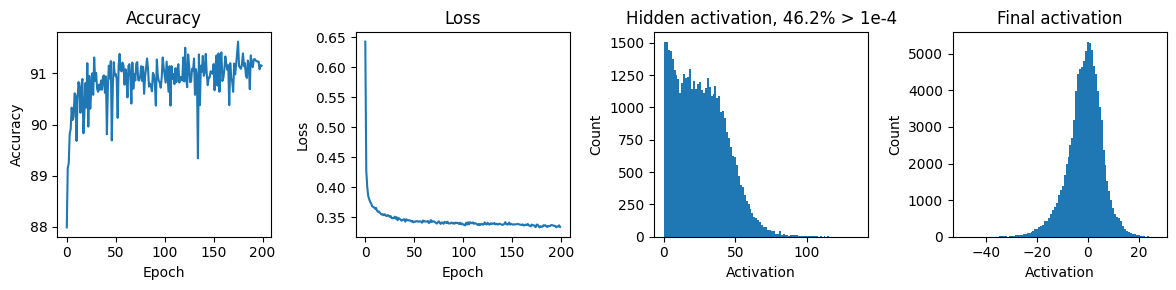

--------------------------------------------------
 Epoch 1/200, Loss: 0.6220, Accuracy: 87.81%
 Epoch 11/200, Loss: 0.3497, Accuracy: 90.66%
 Epoch 21/200, Loss: 0.3267, Accuracy: 91.68%
 Epoch 31/200, Loss: 0.3194, Accuracy: 92.09%
 Epoch 41/200, Loss: 0.3110, Accuracy: 91.50%
 Epoch 51/200, Loss: 0.3082, Accuracy: 92.12%
 Epoch 61/200, Loss: 0.3069, Accuracy: 91.62%
 Epoch 71/200, Loss: 0.3030, Accuracy: 92.05%
 Epoch 81/200, Loss: 0.2997, Accuracy: 92.18%
 Epoch 91/200, Loss: 0.2999, Accuracy: 91.86%
 Epoch 101/200, Loss: 0.3006, Accuracy: 92.14%
 Epoch 111/200, Loss: 0.3013, Accuracy: 92.23%
 Epoch 121/200, Loss: 0.2991, Accuracy: 91.79%
 Epoch 131/200, Loss: 0.2981, Accuracy: 92.12%
 Epoch 141/200, Loss: 0.3001, Accuracy: 91.47%
 Epoch 151/200, Loss: 0.2983, Accuracy: 91.98%
 Epoch 161/200, Loss: 0.2985, Accuracy: 91.80%
 Epoch 171/200, Loss: 0.2963, Accuracy: 91.85%
 Epoch 181/200, Loss: 0.2998, Accuracy: 92.05%
 Epoch 191/200, Loss: 0.2984, Accuracy: 91.40%


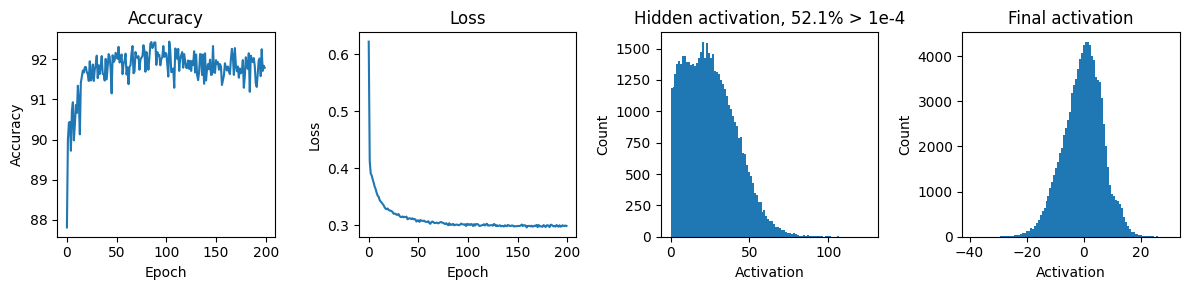

--------------------------------------------------
 Epoch 1/200, Loss: 0.6265, Accuracy: 88.28%
 Epoch 11/200, Loss: 0.3737, Accuracy: 90.06%
 Epoch 21/200, Loss: 0.3573, Accuracy: 90.43%
 Epoch 31/200, Loss: 0.3494, Accuracy: 90.59%
 Epoch 41/200, Loss: 0.3441, Accuracy: 91.07%
 Epoch 51/200, Loss: 0.3422, Accuracy: 90.79%
 Epoch 61/200, Loss: 0.3404, Accuracy: 91.54%
 Epoch 71/200, Loss: 0.3388, Accuracy: 91.46%
 Epoch 81/200, Loss: 0.3396, Accuracy: 91.45%
 Epoch 91/200, Loss: 0.3384, Accuracy: 91.08%
 Epoch 101/200, Loss: 0.3398, Accuracy: 91.31%
 Epoch 111/200, Loss: 0.3379, Accuracy: 91.04%
 Epoch 121/200, Loss: 0.3374, Accuracy: 91.51%
 Epoch 131/200, Loss: 0.3354, Accuracy: 91.39%
 Epoch 141/200, Loss: 0.3351, Accuracy: 91.43%
 Epoch 151/200, Loss: 0.3364, Accuracy: 91.23%
 Epoch 161/200, Loss: 0.3358, Accuracy: 90.92%
 Epoch 171/200, Loss: 0.3371, Accuracy: 91.48%
 Epoch 181/200, Loss: 0.3355, Accuracy: 90.76%
 Epoch 191/200, Loss: 0.3363, Accuracy: 91.31%


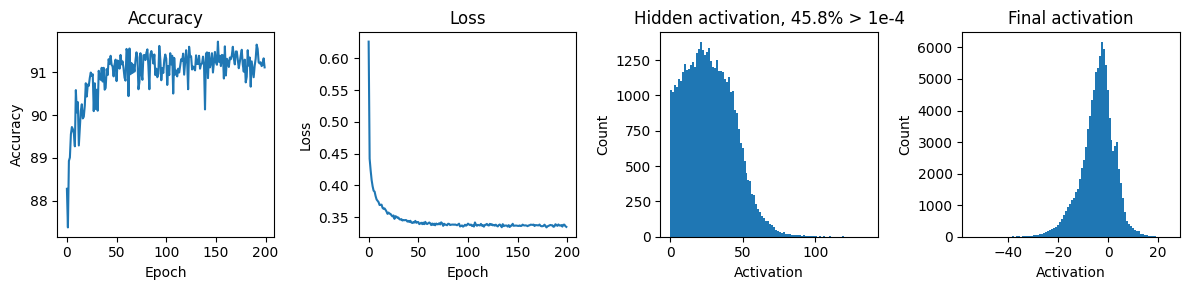

--------------------------------------------------
 Epoch 1/200, Loss: 0.7118, Accuracy: 85.92%
 Epoch 11/200, Loss: 0.3702, Accuracy: 89.99%
 Epoch 21/200, Loss: 0.3539, Accuracy: 90.27%
 Epoch 31/200, Loss: 0.3482, Accuracy: 89.69%
 Epoch 41/200, Loss: 0.3461, Accuracy: 91.03%
 Epoch 51/200, Loss: 0.3434, Accuracy: 90.88%
 Epoch 61/200, Loss: 0.3440, Accuracy: 90.82%
 Epoch 71/200, Loss: 0.3420, Accuracy: 91.14%
 Epoch 81/200, Loss: 0.3417, Accuracy: 90.96%
 Epoch 91/200, Loss: 0.3383, Accuracy: 91.13%
 Epoch 101/200, Loss: 0.3415, Accuracy: 90.94%
 Epoch 111/200, Loss: 0.3392, Accuracy: 91.13%
 Epoch 121/200, Loss: 0.3379, Accuracy: 91.07%
 Epoch 131/200, Loss: 0.3390, Accuracy: 90.96%
 Epoch 141/200, Loss: 0.3338, Accuracy: 91.38%
 Epoch 151/200, Loss: 0.3335, Accuracy: 91.17%
 Epoch 161/200, Loss: 0.3311, Accuracy: 91.35%
 Epoch 171/200, Loss: 0.3311, Accuracy: 91.24%
 Epoch 181/200, Loss: 0.3355, Accuracy: 91.20%
 Epoch 191/200, Loss: 0.3338, Accuracy: 91.03%


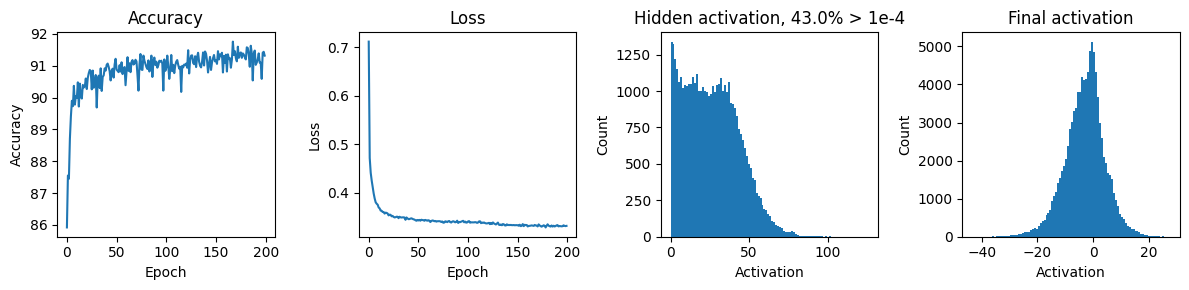

--------------------------------------------------
 Epoch 1/200, Loss: 0.7061, Accuracy: 86.77%
 Epoch 11/200, Loss: 0.3843, Accuracy: 90.49%
 Epoch 21/200, Loss: 0.3661, Accuracy: 90.69%
 Epoch 31/200, Loss: 0.3557, Accuracy: 90.42%
 Epoch 41/200, Loss: 0.3505, Accuracy: 91.16%
 Epoch 51/200, Loss: 0.3491, Accuracy: 91.16%


: 

In [8]:
result = []
for i in range(10):
    torch.manual_seed(i)
    model = TwoLayerNN(
        input_dim,  
        hidden_dim, 
        output_dim,  
    )
    result.append(train_models_NN(model, trainloader, testloader, num_epochs = 200, verbose = True, regularization=0, model_type='2NN'))
    
    hidden, final = get_hidden_final_activation_2NN(model, testloader)
    plot_hidden_final_loss_2NN(model, hidden, final, result[-1])
    
    

    with open('result_2NN_softmax_H_{:d}.pickle'.format(hidden_dim), 'wb') as f:
        pickle.dump(result, f)
    print('--------------------------------------------------')

In [6]:
plot_hidden_final_loss_2NN(model, hidden, result[0])

TypeError: plot_hidden_final_loss_2NN() missing 1 required positional argument: 'result'

In [ ]:
model.parallel_synapse.thres.data.max()

tensor(21.3914)